In [0]:
#Traemos el dataset desde la pagina de github
!git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

fatal: destination path 'Sign-Language-Digits-Dataset' already exists and is not an empty directory.


In [0]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

1.15.0


In [0]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 32 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        '/content/Sign-Language-Digits-Dataset/Dataset',
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        '/content/Sign-Language-Digits-Dataset/Dataset',
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        subset = 'validation',
        batch_size=bs)

Found 1653 images belonging to 10 classes.
Found 409 images belonging to 10 classes.


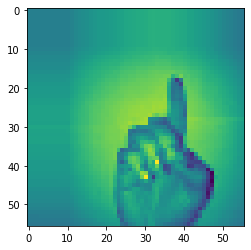

In [0]:
#Printeado de imagenes despues de haber pasado por el generador

plt.imshow(next(train_generator)[0][2,...,0])
plt.show()

In [0]:
#Para saber a qué clase se le asocia a cada letra
print(train_generator.class_indices)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


In [0]:
#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________

In [0]:
##DEFINIMOS EL MODELO
num_classes = 10
epochs = 50

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [0]:
## EJECUCION DEL MODELO
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model', verbose=1, save_best_only=True,
                               monitor = 'val_acc', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit_generator(train_generator,validation_data = valid_generator, 
                             callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/50
13/52 [======>.......................] - ETA: 10s - loss: 3.3115 - acc: 0.2616
Epoch 00001: val_acc improved from -inf to 0.26161, saving model to model
52/52 [==============================] - 14s 270ms/step - loss: 3.5121 - acc: 0.1579 - val_loss: 3.3115 - val_acc: 0.2616
Epoch 2/50
13/52 [======>.......................] - ETA: 8s - loss: 3.1280 - acc: 0.2861
Epoch 00002: val_acc improved from 0.26161 to 0.28606, saving model to model
52/52 [==============================] - 10s 192ms/step - loss: 3.2716 - acc: 0.2353 - val_loss: 3.1280 - val_acc: 0.2861
Epoch 3/50
13/52 [======>.......................] - ETA: 8s - loss: 2.9390 - acc: 0.3570
Epoch 00003: val_acc improved from 0.28606 to 0.35697, saving model to model
52/52 [==============================] - 10s 198ms/step - loss: 3.0405 - acc: 0.3170 - val_loss: 2.9390 - val_acc: 0.3570
Epoch 4/50
13/52 [======>.......................] - ETA: 8s - loss: 2.7518 - acc: 0.4425
Epoch 00004: val_acc improved from 0.35697 to 0.4

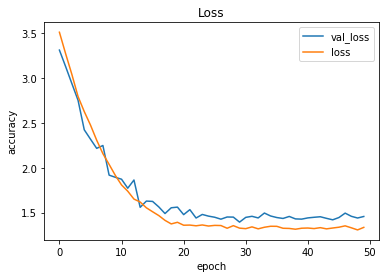

In [0]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['val_loss','loss'])
plt.show()